In [1]:
import os
import glob
import itertools
import json
import importlib

import pingouin as pg
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.objects.selectivity as sel

import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Aggregate

In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [3]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                                  create_new=False,
                                                  return_cells=True, return_missing=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
             datakey  cell
visual_area               
Li              3661  3661
Lm              4366  4366
V1              4028  4028


In [4]:
experiment='blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled


# Output plotting

In [20]:
aggregate_dir= '/n/coxfs01/julianarhee/aggregate-visual-areas'
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
bw_area_colors={'V1': [0.7]*3, 'Lm': [0.7]*3, 'Li': [0.7]*3}
# fontsize=6
# lw=0.25

dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', \
                       'selectivity_tolerance', 'final')
print(dst_dir)
if not os.path.exists(os.path.join(dst_dir,'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))
data_id = '%s|%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
print(data_id)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final
traces001|dff_ROC-0.05


In [21]:
# exclude =[] # ['20190627_JC091_fov1', '20191111_JC120_fov1', '20190506_JC080_fov1']

# NDATA0 = NDATA_[~(NDATA_.datakey.isin(exclude))].copy()



In [22]:
filter_rfs=False
if filter_rfs:
    cells_overlap = dec.get_cells_with_overlap(assigned_cells, sdata, 
                                 greater_than=False,
                                overlap_thr=0.)
    NDATA0_rf = aggr.get_neuraldata_for_included_cells(cells_overlap, NDATA0)
    curr_counts = NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()
else:
    curr_counts = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()

n_cells_all = aggr.count_n_cells(curr_counts, name='cell')

In [23]:
# # # Get unique dkeys and count
# u_dkeys = aggr.drop_repeats(n_cells_all)
# min_ncells=20
# if filter_rfs:
#     NDATA_all = pd.concat([g for (va, dk), g in NDATA0_rf.groupby(['visual_area', 'datakey'])\
#                    if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
# else:
#     NDATA_all = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
#                    if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

In [24]:
SDF, incorrect_stims = aggr.check_sdfs(NDATA0['datakey'].unique(),
                      experiment='blobs', rename=True, images_only=False,
                      return_incorrect=True, return_all=False)
print(incorrect_stims.keys())

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])


In [25]:
min_ncells=10
enough_cells = [(k, v) for k, v in n_cells_all[n_cells_all['cell']>min_ncells]\
                [['visual_area', 'datakey']].drop_duplicates().values]
correct_stims = SDF['datakey'].unique()
# -----------------------------------
NDATA_ = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in enough_cells and dk in correct_stims])

In [26]:
'20190322_JC073_fov1' in NDATA_['datakey'].unique()

False

In [27]:
NDATA_im = None
i_=[]
for (va, dk), ndf in NDATA_.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment='blobs', match_names=True)
    im_df = sel.exclude_lum_is_best(ndf, sdf)
    i_.append(im_df)
NDATA_im = pd.concat(i_, axis=0, ignore_index=True)

## Count fraction lum-preferring

In [28]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [29]:
totals, cnt_each = sel.count_fraction_luminance_preferring(NDATA_, NDATA_im)

<IPython.core.display.Javascript object>


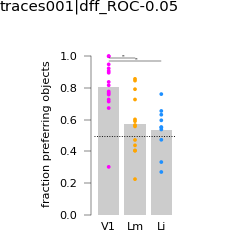

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [30]:
%matplotlib notebook
metric = 'pref_object'
fig, ax = pl.subplots(figsize=(2,2), dpi=150)
pplot.stripplot_metric_by_area(cnt_each, metric, area_colors=area_colors,ax=ax,
                            markersize=2, ylim=(0,1.02), 
                            sig_fontsize=2, jitter=False, 
                            plot_means=True, y_loc=0.95, offset=0.02,
                            mean_style='bar', mean_type='mean', aspect=2)
ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('fraction preferring objects')
sns.despine(bottom=True, trim=True)

pplot.label_figure(fig, data_id)
figname = 'fraction_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


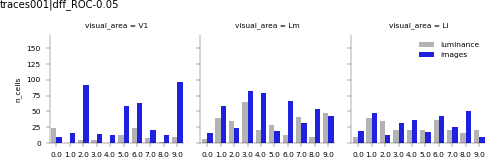

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [31]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', height=2, col_order=visual_areas,
            data=totals[totals.stimuli.isin(['luminance', 'images'])])
fg.map(sns.barplot, 'site_num', 'n_cells', 'stimuli', 
       palette={'luminance': [0.7]*3, 'images': 'blue'})
totals.groupby('visual_area').min()
fg.fig.axes[-1].legend(frameon=False)
pl.subplots_adjust(bottom=0.2, right=0.9, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'n_lum_preferring_hists'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [32]:
exclude_by_fraction=False
min_pref_lum = 0.5 if exclude_by_fraction else 1.0
if exclude_by_fraction:
    pref_obj = [(k, v) for k, v in \
                cnt_each[cnt_each['pref_luminance']<min_pref_lum]\
                [['visual_area', 'datakey']].values]
    NDATA1 = pd.concat([g for (va, dk), g in NDATA_.groupby(['visual_area', 'datakey'])\
                           if (va, dk) in pref_obj])
else:
    NDATA1 = NDATA_.copy()

In [33]:
curr_counts = NDATA1[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
u_dkeys = aggr.drop_repeats(n_cells_all)
NDATA_all = pd.concat([g for (va, dk), g in NDATA1.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

[V1] Animalid does not exist: JC078 


In [34]:
NDATA_im = None
i_=[]
for (va, dk), ndf in NDATA_all.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment='blobs', match_names=True)
    im_df = sel.exclude_lum_is_best(ndf, sdf)
    i_.append(im_df)
NDATA_im = pd.concat(i_, axis=0) #, ignore_index=True)

In [35]:
totals, cnt_each = sel.count_fraction_luminance_preferring(NDATA_all, NDATA_im)

<IPython.core.display.Javascript object>


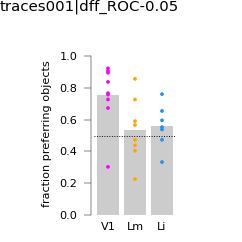

In [36]:
%matplotlib notebook
metric = 'pref_object'
fig, ax = pl.subplots(figsize=(2,2), dpi=150)
pplot.stripplot_metric_by_area(cnt_each, metric, area_colors=area_colors,ax=ax,
                            markersize=2, ylim=(0,1.02), 
                            sig_fontsize=2, jitter=False, 
                            plot_means=True, y_loc=0.95, offset=0.02,
                            mean_style='bar', mean_type='mean', aspect=2)
ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('fraction preferring objects')
sns.despine(bottom=True, trim=True)

pplot.label_figure(fig, data_id)
figname = 'fraction_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


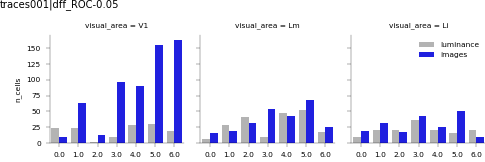

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [37]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', height=2, col_order=visual_areas,
            data=totals[totals.stimuli.isin(['luminance', 'images'])])
fg.map(sns.barplot, 'site_num', 'n_cells', 'stimuli', 
       palette={'luminance': [0.7]*3, 'images': 'blue'})
totals.groupby('visual_area').min()
fg.fig.axes[-1].legend(frameon=False)
pl.subplots_adjust(bottom=0.2, right=0.9, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'n_lum_preferring_hists'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Aggregate metrics

In [38]:
# SDF, mislabeled = aggr.check_sdfs(meta['datakey'].unique(), experiment=experiment,
#                      images_only=False, rename=True, return_incorrect=True,
#                      return_all=True)

In [39]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [122]:
exclude=[] # wrong configs
offset_type = 'none'
lcorrection = 'exclude'
filter_str = 'offset-%s_lum-%s' % (offset_type, lcorrection)
print(filter_str)

NDATA = NDATA_all.copy() #0.copy() # NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
# ----------------------------------------------------------------
ixdf = sel.aggregate_cell_metrics(NDATA, offset_type=offset_type, 
                                 lcorrection=lcorrection)
print(ixdf['n_cells'].min())

offset-none_lum-exclude
13


In [123]:
min_ncells=10
print(ixdf.shape)
lum_cols = [k for k in ixdf.columns if 'lum' in k]
if lcorrection=='normalize':
    for k in lum_cols:
        ixdf = ixdf.drop(k, 1)
for va, vg in ixdf.groupby('visual_area'):
    dk_lut = dict((v, i) for i, v in enumerate(vg['datakey'].unique()))
    ixdf.loc[vg.index, 'site_num'] = [dk_lut[k] for k in vg['datakey'].values]
DF = ixdf[ixdf['n_cells']>=min_ncells].copy().dropna()
print(ixdf.shape, ixdf.dropna().shape, DF.shape)

(1266, 13)
(1266, 14) (1266, 14) (1266, 14)


In [124]:
print('size_tol', ixdf[(ixdf['size_tol']>1) | (ixdf['size_tol']<0)].shape)
print('morph_sel', ixdf[(ixdf['morph_sel']>1) | (ixdf['morph_sel']<0)].shape)
print('sparseness_morphs', ixdf[(ixdf['sparseness_morphs']>1) | (ixdf['sparseness_morphs']<0)].shape)

size_tol (0, 14)
morph_sel (0, 14)
sparseness_morphs (0, 14)


In [125]:
# Get means by FOV
means_by_fov = DF.groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = DF.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
fovdf = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

## By fov metrics

[median]:
  visual_area  sparseness_morphs  morph_sel  size_tol   lum_sel  lum_size_cc  \
0          Li           0.178296   0.458238  0.374125  0.544978     0.147835   
1          Lm           0.226093   0.480436  0.344112  0.588004     0.041580   
2          V1           0.226515   0.391658  0.399075  0.568953     0.242429   

   sparseness_morphs_std  morph_sel_std  size_tol_std  lum_sel_std  \
0               0.020586       0.062996      0.072290     0.096099   
1               0.024483       0.049978      0.036780     0.092132   
2               0.017360       0.050266      0.039089     0.053396   

   lum_size_cc_std  
0         0.237769  
1         0.247842  
2         0.260866  


<IPython.core.display.Javascript object>


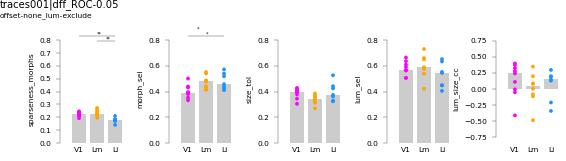

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final metrics_byFOV_offset-none_lum-exclude


In [143]:
%matplotlib notebook
plot_params=['sparseness_morphs','morph_sel', 'size_tol', 'lum_sel', 'lum_size_cc']

mean_type='median'
multi_comp_test='fdr_by' #'fdr_bh'
markersize = 3
fw=7
ymax=0.8 + 0.04
plotdf = fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
                  metric=mean_type)
fig, axn = pl.subplots(1, len(plot_params), figsize=(fw, 2), 
                       sharex=True, sharey=False)
for ai, metric in enumerate(plot_params):
    ax=axn[ai]
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=ymax-0.05, offset=0.04,
                                mean_style='bar', mean_type=mean_type, aspect=2)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.6)
sns.despine(offset=8, trim=True, bottom=True)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byFOV_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

[median]:
  visual_area  sparseness_morphs  morph_sel  size_tol   lum_sel  lum_size_cc  \
0          Li           0.179304   0.472386  0.386698  0.552719     0.127357   
1          Lm           0.228548   0.473830  0.336947  0.618824    -0.037845   
2          V1           0.217560   0.402128  0.400037  0.581877     0.190564   

   sparseness_morphs_std  morph_sel_std  size_tol_std  lum_sel_std  \
0               0.080415       0.141078      0.147898     0.193791   
1               0.093930       0.160954      0.141984     0.175036   
2               0.096337       0.166518      0.164791     0.168623   

   lum_size_cc_std  
0         0.557180  
1         0.587799  
2         0.558502  


<IPython.core.display.Javascript object>


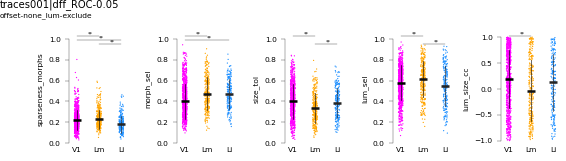

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final metrics_byCELL_offset-none_lum-exclude


In [140]:
%matplotlib notebook
mean_type = 'median'
multi_comp_test='fdr_bh' #'fdr_bh'

fw=7
markersize = 1 

plotdf = DF.dropna().copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
              metric=mean_type)
fig, axn = pl.subplots(1, len(plot_params), figsize=(fw, 2), 
                       sharex=True, sharey=False)
for ai, metric in enumerate(plot_params):
    ax=axn[ai]
    ylim=(-1.04,1.04) if metric=='lum_size_cc' else (0, 1.04)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, aspect=2,
                                plot_means=True, y_loc=0.95, offset=0.04,
                                mean_style='point', mean_type=mean_type)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.5)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byCELL_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


# Tradeoff

In [128]:
r_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    p_r, p_p = spstats.pearsonr(df_['morph_sel'], df_['size_tol'])
    res = pd.Series({'pearson_r': p_r, 'pearson_p': p_p,
               'visual_area': va, 'datkey': dk, 'n_cells': len(df_)})
    r_.append(res)
tradeoff = pd.concat(r_, axis=1, ignore_index=True).T
tradeoff['pearson_r'] = tradeoff['pearson_r'].astype(float)
tradeoff['pearson_p'] = tradeoff['pearson_p'].astype(float)

<IPython.core.display.Javascript object>


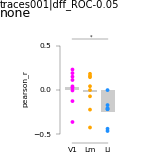

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final tradeoff-pearsonr_offset-none_lum-exclude


In [139]:
metric = 'pearson_r'
fig, ax = pl.subplots(figsize=(2, 2))
pplot.stripplot_metric_by_area(tradeoff, metric, area_colors=area_colors,
                                markersize=3, ylim=(-1.04, 1.04), ax=ax,
                                sig_fontsize=4, jitter=False, aspect=2,
                                plot_means=True, y_loc=0.54, offset=0.04,
                                mean_type='mean', mean_style='bar')
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_ylim([-0.6, 0.62])
sns.despine(trim=True, ax=ax)
pplot.label_figure(fig, data_id)
fig.text(0, 0.9, offset_type)
figname = 'tradeoff-pearsonr_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


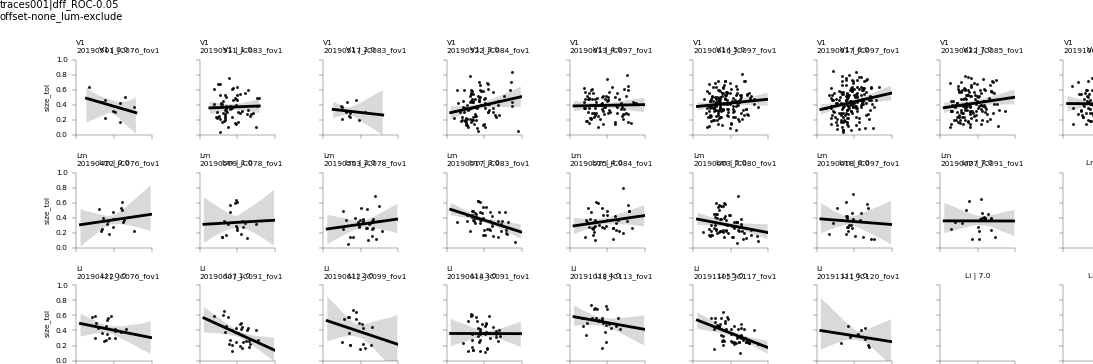

V1 0.0
V1 1.0
V1 2.0
V1 3.0
V1 4.0
V1 5.0
V1 6.0
V1 7.0
V1 8.0
Lm 0.0
Lm 1.0
Lm 2.0
Lm 3.0
Lm 4.0
Lm 5.0
Lm 6.0
Lm 7.0
Lm 8.0
Li 0.0
Li 1.0
Li 2.0
Li 3.0
Li 4.0
Li 5.0
Li 6.0
Li 7.0
Li 8.0
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final tradeoff_eachfov_ offset-none_lum-exclude


In [138]:
fg = sns.FacetGrid(col='site_num', row='visual_area', row_order=visual_areas,
                   data=DF, height=1.5)
fg.map(sns.regplot, 'morph_sel', 'size_tol',
            truncate=False, color='k', scatter_kws={'s':2})
# DF["group"] = DF["site_num"].map(dict((k, v) for k, v in DF[['site_num', 'datakey']].values))

for ax in fg.axes.flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
pl.subplots_adjust(top=0.85)
    
[pl.setp(ax.texts, text="") for ax in fg.axes.flat] # remove the original texts
fg.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = fg.axes.flatten()
for ax in axes:
    currt = ax.get_title()
    va = currt.split(' ')[0]
    snum = float(currt.split(' ')[2])
    print(va, snum)
    dk = DF[(DF.visual_area==va) & (DF['site_num']==snum)]['datakey'].unique()
    if len(dk)==0:
        continue
    new_t = '%s\n%s' % (va, dk[0])
    ax.set_title(new_t, fontsize=6, loc='left')
pl.subplots_adjust(left=0.05, right=0.95, hspace=0.5)
fg.fig.text(0.0, 0.95, filter_str, fontsize=8)

pplot.label_figure(fg.fig, data_id)
figname = 'tradeoff_eachfov_ %s' % filter_str 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


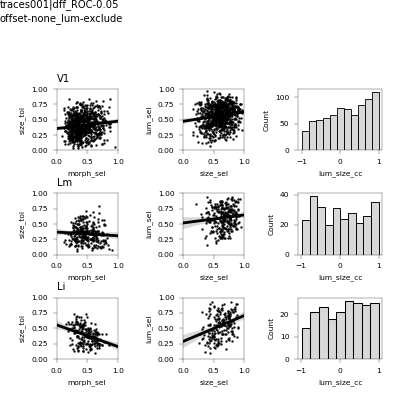

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final tradeoff_allcells_offset-none_lum-exclude


In [137]:
fig, axn = pl.subplots(3,3, figsize=(5,5))
for ax in axn[:, 0:-1].flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
for va, ixs_ in DF.dropna().groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[vi, 0]
    ax.set_title(va, loc='left')
    sns.regplot(x='morph_sel', y='size_tol', data=ixs_, ax=ax, 
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 1]
    sns.regplot(x='size_sel', y='lum_sel', data=ixs_, ax=ax,
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 2]
    sns.histplot(x='lum_size_cc', data=ixs_, ax=ax,
                color=[0.8]*3)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5,
                  hspace=0.7)

fig.text(0.0, 0.95, filter_str, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'tradeoff_allcells_%s' % filter_str 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

## Population sparseness

In [132]:
#x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
remove_offset=False # Set false, offsets removed if neg. in calculatin index
NDATA = NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
pop_sparse = sel.aggregate_population_sparseness(NDATA, offset_type=offset_type)
popdf = pop_sparse[(pop_sparse['pop-sparseness']<=1.0) 
                 & (pop_sparse['pop-sparseness']>=0)].copy()
print(pop_sparse.shape, popdf.shape)

(1200, 5) (1200, 5)


In [133]:
pDF = popdf[popdf['n_cells']>=min_ncells].copy().dropna()
print(pDF.shape)
pop_by_fov = pDF.groupby(['visual_area', 'datakey']).mean().reset_index()
pop_by_config = pDF.groupby(['visual_area', 'config']).mean().reset_index()

(1200, 5)


<IPython.core.display.Javascript object>


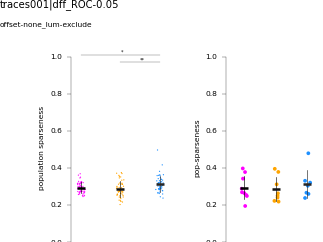

[mean]:
  visual_area  pop-sparseness  pop-sparseness_std
0          Li        0.313741            0.044675
1          Lm        0.284518            0.043408
2          V1        0.292555            0.029905
[mean]:
  visual_area  pop-sparseness  pop-sparseness_std
0          Li        0.313741            0.080324
1          Lm        0.284518            0.069471
2          V1        0.292555            0.066248
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final population_sparseness_offset-none_lum-exclude


In [136]:
%matplotlib notebook
metric = 'pop-sparseness'
multi_comp_test='fdr_bh' #'fdr_bh'

stat_cols = ['A', 'B', 'p-unc', 'p-corr', 'p-adjust', 'eta-square']
ylim = (0, 1.02)
y_loc = ylim[-1]-0.05

fig, axn = pl.subplots(1,2, figsize=(4,3))
for ai, ax in enumerate(axn.flat):
    plotdf = pop_by_config.dropna().copy() if ai==0 else pop_by_fov.copy()
    markersize = 1 if ai==0 else 3
    pplot.print_means(plotdf, groupby=['visual_area'], params=[metric], metric='mean')
    pplot.stripplot_metric_by_area(plotdf, metric=metric, ax=ax, mean_type='mean',
                            area_colors=area_colors, markersize=markersize,
                            y_loc=y_loc, sig_lw=0.2, offset=0.04, sig_fontsize=4,
                            ylim=ylim, aspect=2)
fig.axes[0].set_ylabel('population sparseness')
pl.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.8, wspace=0.6)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'population_sparseness_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [135]:
'20190603_JC080_fov1' in NDATA0['datakey'].unique()

True

In [353]:
import analyze2p.extraction.traces as traceutils

In [354]:
importlib.reload(traceutils)

<module 'analyze2p.extraction.traces' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/traces.py'>

In [355]:
dk = '20190506_JC080_fov1'
sdf = aggr.get_stimuli(dk, experiment='blobs')
soma_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs',
                                       trace_type='np_subtracted')
raw_traces, labels, sdf, _ = traceutils.load_dataset(soma_fpath, 
                                    trace_type='corrected', add_offset=True, 
                                    create_new=True, save=False)

... processing data arrays, no save (corrected).
    adding raw offset (raw f0 offset: 551.30)
    adding raw offset (raw f0 offset: 93.05)


In [356]:
dff_traces, metrics = aggr.process_traces(raw_traces, labels, trace_type='dff',
                                        response_type='dff', 
                                        trial_epoch='stimulus')

--- processed traces: dff


In [357]:
metrics['visual_area'] = va
metrics['datakey'] = dk
metrics.loc[metrics.index, 'trial'] = metrics.index.tolist()

ndf = pd.melt(metrics, id_vars=['visual_area', 'datakey', 'config', 'trial'], var_name='cell', 
              value_name='response')

In [362]:
rdf0 = ndf.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()
print(rdf0['response'].min(), rdf0['response'].max())
rdf = sel.correct_offset(rdf0, offset='minsub')
print(rdf['response'].min(), rdf['response'].max())

-2.039759962278916 0.7086775120989621
0.0 2.3673981233120944


In [363]:
ixs_ = sel.calculate_metrics(rdf, sdf)

<IPython.core.display.Javascript object>


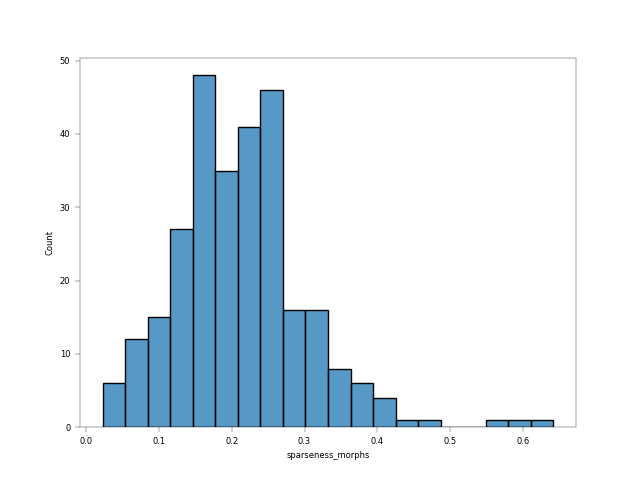

<AxesSubplot:xlabel='sparseness_morphs', ylabel='Count'>

In [364]:
# dk = '20190506_JC080_fov1'

fig, ax = pl.subplots()
sns.histplot(ixs_['sparseness_morphs'])


In [365]:
ixs_[ixs_['sparseness_morphs']==ixs_['sparseness_morphs'].max()]


,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell
68,0.931275,0.074335,0.618336,0.641299,0.233219,0.925665,0.75703,-0.217338,0.72547,68


In [366]:
ixs_[ixs_['sparseness_morphs']==ixs_['sparseness_morphs'].min()]


,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell
26,0.153983,0.971997,0.020868,0.023009,0.000205,0.028003,0.080561,-0.723343,0.167243,26


In [86]:
import analyze2p.correlations as cr

In [87]:
def do_pairwise_diffs_melt(df_, metric_name='morph_sel', include_diagonal=False):
    pairwise_diffs = pd.DataFrame(abs(df_[metric_name].values \
                                  - df_[metric_name].values[:, None]), 
                              columns=df_['cell'].values, index=df_['cell'].values)

    diffs = cr.melt_square_matrix(pairwise_diffs, metric_name=metric_name)
    diffs = diffs.rename(columns={'row': 'cell_1', 'col': 'cell_2'})
    diffs[['cell_1', 'cell_2']] = diffs[['cell_1', 'cell_2']].astype(int)
    diffs['neuron_pair'] = ['%i_%i' % (c1, c2) for \
                         c1, c2 in diffs[['cell_1', 'cell_2']].values]
    return diffs


In [88]:
DF['experiment'] = 'blobs'
DF = aggr.add_roi_positions(DF)

In [89]:
va = 'V1'
dk = '20191006_JC110_fov1'
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
df_.head()

,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
1337,0.592004,0.728200,0.175357,0.141727,0.212171,0.271800,0.774502,-0.051729,0.934167,4,...,blobs,JC110,FOV1_zoom2p0x,20191006,251.190607,109.0,51.400391,27.0,921.399609,926.409393
1338,0.113957,0.647360,0.129247,0.110111,0.063657,0.352640,0.224575,0.088116,0.887952,5,...,blobs,JC110,FOV1_zoom2p0x,20191006,235.059100,102.0,89.474755,47.0,883.325245,942.540900
1339,0.276746,0.485549,0.237714,0.209670,0.218234,0.514451,0.772925,0.617586,0.266994,11,...,blobs,JC110,FOV1_zoom2p0x,20191006,232.754599,101.0,72.341292,38.0,900.458708,944.845401
1340,0.399469,0.414261,0.229796,0.196078,0.232018,0.585739,0.550042,0.207764,0.737383,24,...,blobs,JC110,FOV1_zoom2p0x,20191006,163.619569,71.0,146.586301,77.0,826.213699,1013.980431
1341,0.431128,0.579382,0.233844,0.210213,0.202011,0.420618,0.522083,-0.489453,0.402673,33,...,blobs,JC110,FOV1_zoom2p0x,20191006,101.398043,44.0,211.312720,111.0,761.487280,1076.201957


In [120]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='morph_sel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='lum_sel')
    d3 = do_pairwise_diffs_melt(df_, metric_name='size_tol')
    d4 = do_pairwise_diffs_melt(df_, metric_name='sparseness_morphs')
    
    diff_ = pd.merge(d1, d2).merge(d3).merge(d4)
    ddf_ = cr.get_pw_distance(diff_, roi_pos, )
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
diffdf = pd.concat(d_, axis=0, ignore_index=True)

In [121]:
fov_means = diffdf.groupby(['visual_area', 'datakey']).mean().reset_index()
fov_means.head()

,visual_area,datakey,cell_1,cell_2,morph_sel,lum_sel,size_tol,sparseness_morphs,cortical_distance
0,Li,20190422_JC076_fov1,212.228070,290.824561,0.138830,0.212143,0.140246,0.101740,300.508467
1,Li,20190602_JC091_fov1,73.975023,186.407956,0.176504,0.257779,0.165620,0.077016,241.740967
2,Li,20190609_JC099_fov1,175.890476,243.942857,0.175799,0.193444,0.147620,0.067895,298.747585
3,Li,20190614_JC091_fov1,154.052049,312.599114,0.138592,0.219539,0.153563,0.097312,304.634686
4,Li,20191018_JC113_fov1,80.583333,122.216667,0.150761,0.193619,0.139770,0.073069,255.527099


<IPython.core.display.Javascript object>


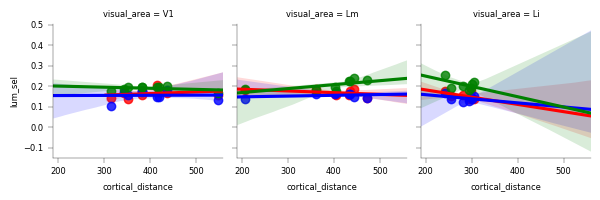

In [122]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fov_means, 
                  height=2)
fg.map(sns.regplot, 'cortical_distance', 'morph_sel', truncate=False,
      color='r')
fg.map(sns.regplot, 'cortical_distance', 'size_tol', truncate=False,
      color='b')
fg.map(sns.regplot, 'cortical_distance', 'lum_sel', truncate=False,
      color='g')

In [132]:
# Binning params
n_bins=100
use_quartile=False
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins)
bcorrs, bins_ = cr.bin_column_values(diffdf, to_quartile=to_quartile, 
                                     use_quartile=use_quartile, return_bins=True,
                                     n_bins=n_bins, bins=bins, labels=bin_labels)

<IPython.core.display.Javascript object>


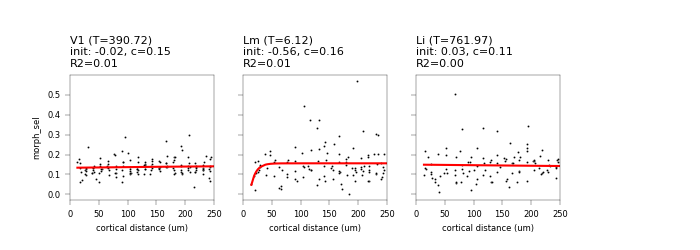

In [133]:
metric = 'morph_sel'
fit_sites=True
min_npairs = 3
n_iter=0
x_var = 'binned_%s' % to_quartile
cnt_grouper = [x_var, 'datakey'] if fit_sites else [x_var]

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    pair_cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(pair_cnts[pair_cnts>min_npairs].index.tolist(),
                               pair_cnts[pair_cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    data = fov_cc.groupby(x_var).median()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)[metric].values
    #ax.plot(xd, yd, lw=0, color='k', marker='.')
    sns.scatterplot(x=to_quartile, y=metric, data=fov_cc, ax=ax,
                    s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                                normalize_x=True, func='halflife',
                                                estimator='median',
                                                metric=metric, #bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (T=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_title(label, loc='left')
    ax.set_xlabel('cortical distance (um)')
    ax.set_xlim([0, 250])
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.7)


In [112]:
va, dk

('V1', '20191006_JC110_fov1')

<IPython.core.display.Javascript object>


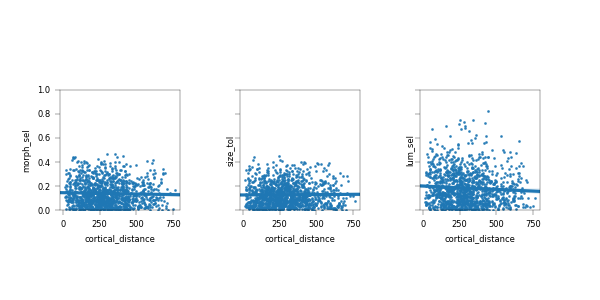

In [98]:
va='Li'
dk='20191105_JC117_fov1'
df_ = diffdf[(diffdf.visual_area==va) & (diffdf.datakey==dk)]

fig, axn = pl.subplots(1,3, figsize=(6, 3), sharex=True, sharey=True)
for ax, metric in zip(axn.flat, ['morph_sel', 'size_tol', 'lum_sel']):
    ax.set_ylim([0, 1])
    #ax.set_aspect('equal')
    sns.regplot(x='cortical_distance', y=metric, data=df_, ax=ax,
               truncate=False, scatter_kws={'s':1})
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.5)

<IPython.core.display.Javascript object>


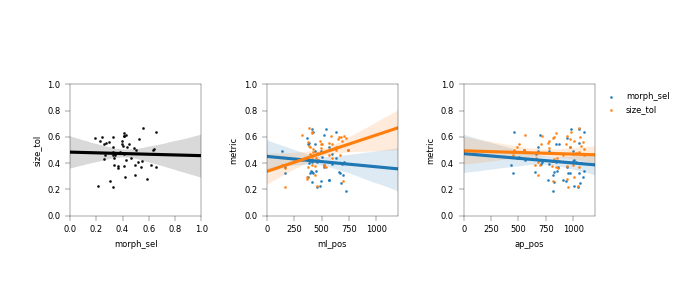

In [99]:
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
fig, axn = pl.subplots(1, 3, figsize=(7, 3), sharex=False, sharey=False)
ax=axn[0]
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_aspect('equal')
sns.regplot(x='morph_sel', y='size_tol', ax=ax, data=df_,
           truncate=False, color='k', scatter_kws={'s':1})

for ax, axis in zip(axn.flat[1:], ['ml_pos', 'ap_pos']):
    ax.set_ylim([0,1])
    ax.set_xlim([0, 1200])
    sns.regplot(x=axis, y='morph_sel', ax=ax, data=df_, label='morph_sel',
               truncate=False, scatter_kws={'s':1})
    sns.regplot(x=axis, y='size_tol', ax=ax, data=df_, label='size_tol',
               truncate=False, scatter_kws={'s':1})
    ax.set_ylabel('metric')
    #ax.set_aspect(0.1)
    #force_aspect(ax,aspect=1)
    ax.set_box_aspect(1)
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [100]:
def get_best_x(rd):
    '''
    Get best morph and best size (rd=ndf[ndf.cell==x])
    '''
    sizr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='size', y='morphlevel', normalize=False)
    best_mp = int(sizr['morphlevel'].unique())

    morphr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='morphlevel', y='size', normalize=False)
    best_sz = int(morphr['size'].unique())

    return pd.Series({'morphlevel': best_mp, 'size': best_sz})



In [101]:
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    ndf = pd.concat([NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) 
              & (NDATA.cell.isin(g['cell'].unique()))] \
                for (va, dk), g in df_.groupby(['visual_area', 'datakey'])]).copy()
    ndf['size'] = sdf.loc[ndf['config'].values]['size'].values
    ndf['morphlevel'] = sdf.loc[ndf['config'].values]['morphlevel'].values
    bestvs = ndf.groupby('cell').apply(get_best_x)
    df_['best_morphlevel'] = bestvs.loc[df_['cell'].values]['morphlevel'].values
    df_['best_size'] = bestvs.loc[df_['cell'].values]['size'].values
    DF.loc[df_.index, 'best_morphlevel'] = df_['best_morphlevel']
    DF.loc[df_.index, 'best_size'] = df_['best_size']

<IPython.core.display.Javascript object>


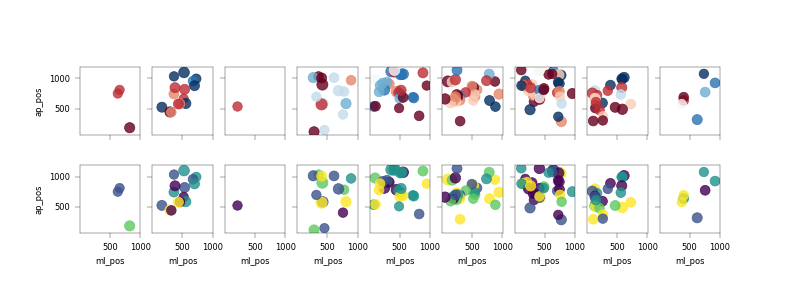

<IPython.core.display.Javascript object>


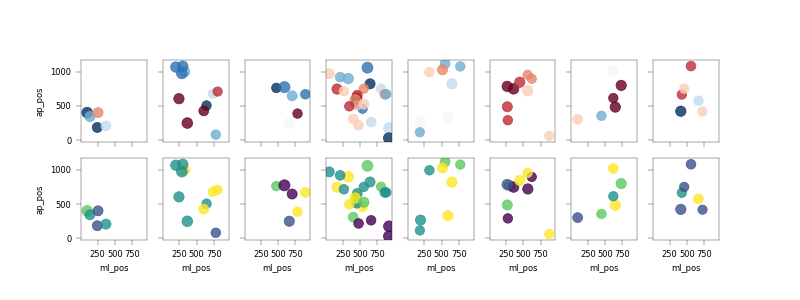

<IPython.core.display.Javascript object>


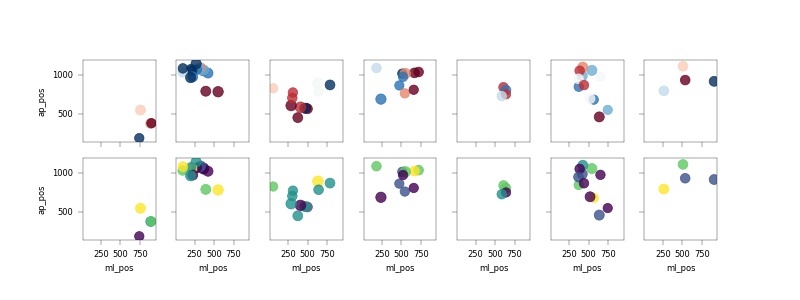

In [149]:
for va in visual_areas:
    plotd = DF[(DF.visual_area==va) & (DF['morph_sel']>=0.5)].copy()

    n_fovs = len(plotd['datakey'].unique())
    fig, axn = pl.subplots(2, n_fovs, figsize=(8, 3), sharex=True, sharey=True)
    size_value='morph_sel'

    for di, (dk, df_) in enumerate(plotd.groupby(['datakey'])):

        for hi, hue_name in enumerate(['best_morphlevel', 'best_size']):
            ax = axn[hi, di]
            metric_cmap = 'RdBu' if hue_name=='best_morphlevel' else 'viridis'
            hue_norm = (0, 106) if hue_name=='best_morphlevel' else (10, 50) 
            sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax, 
                        size=size_value, size_norm=(0, 1), palette=metric_cmap,
                        hue=hue_name, hue_norm=hue_norm, marker='o',
                        edgecolor=None, alpha=0.8, legend=False)
            ax.set_aspect('equal')
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


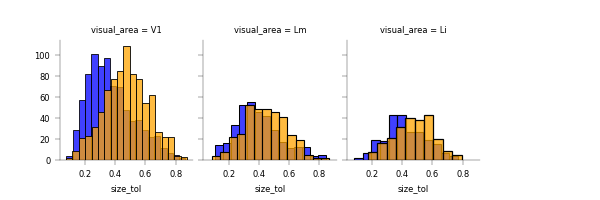

In [150]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=DF,
                  height=2)
fg.map(sns.histplot, 'morph_sel', color='blue')
fg.map(sns.histplot, 'size_tol', color='orange')

pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

<IPython.core.display.Javascript object>


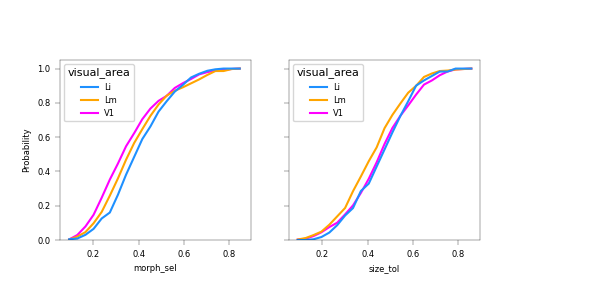

In [108]:
fig, axn=pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
sns.histplot(x='morph_sel', hue='visual_area', data=DF, ax=axn[0],
            palette=area_colors, stat='probability', fill=False,
            cumulative=True, common_norm=False, element='poly')
sns.histplot(x='size_tol', hue='visual_area', data=DF, ax=axn[1],
            palette=area_colors, stat='probability',fill=False,
            cumulative=True, common_norm=False, element='poly')
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

In [179]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='best_morphlevel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='best_size')
    diff_ = pd.merge(d1, d2)
    ddf_ = cr.get_pw_distance(diff_, roi_pos)
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
bestdiffs = pd.concat(d_, axis=0, ignore_index=True)

In [185]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
n_iterations=500
n_samples=None
# ------------------------------
# Get bins
to_quartile='cortical_distance'
n_bins=100
use_quartile=False
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
# Bin ---------------------------------------------------
bcorrs, bins_ = cr.bin_column_values(bestdiffs, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]


<IPython.core.display.Javascript object>


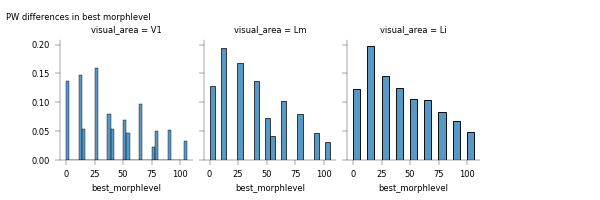

Text(0.01, 0.9, 'PW differences in best morphlevel')

In [186]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2, data=bestdiffs)
fg.map(sns.histplot, 'best_morphlevel', stat='probability', common_norm=False)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

fg.fig.text(0.01, 0.9, 'PW differences in best morphlevel')

<IPython.core.display.Javascript object>


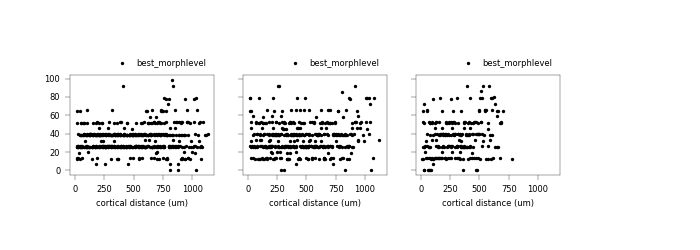

    val out of bounds
BINNED, no fit: Li
    val out of bounds
BINNED, no fit: Lm
    val out of bounds
BINNED, no fit: V1


In [187]:
n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 3
x_var = 'binned_%s' % to_quartile
metric = 'best_morphlevel'
fit_sites = True
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
    
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    # plot
    ax.scatter(x=to_quartile, y=metric, data=fov_cc, 
                s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
       #ax.set_title(va)
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [188]:
min_ncells=20
final_counts = DF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
curr_ds = final_counts[ (final_counts['cell']>=min_ncells)]

In [189]:
max_nfovs = curr_ds['visual_area'].value_counts().max()
max_nfovs

8

<IPython.core.display.Javascript object>


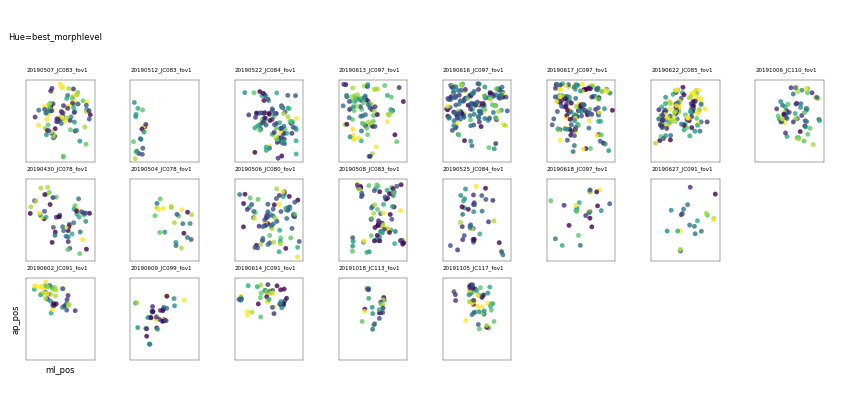

Text(0.01, 0.9, 'Hue=best_morphlevel')

In [192]:
metric = 'best_morphlevel'
cmap='viridis'
fig, axn = pl.subplots(3, max_nfovs, sharex=True, sharey=True, figsize=(8.5,4))
for va, curr_ in curr_ds.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, (va, dk, nc) in enumerate(curr_.values):
        ax=axn[vi, ai]
        ax.set_title(dk, fontsize=4, loc='left')
        df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]

        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, s=10, 
                        edgecolor=None, alpha=0.8, legend=False)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axn[vi, ai+1:].flat:
        ax.axis('off')
pl.subplots_adjust(left=0.02, right=0.98, bottom=0.1, top=0.8)
fig.text(0.01, 0.9, 'Hue=%s' % metric)

<IPython.core.display.Javascript object>


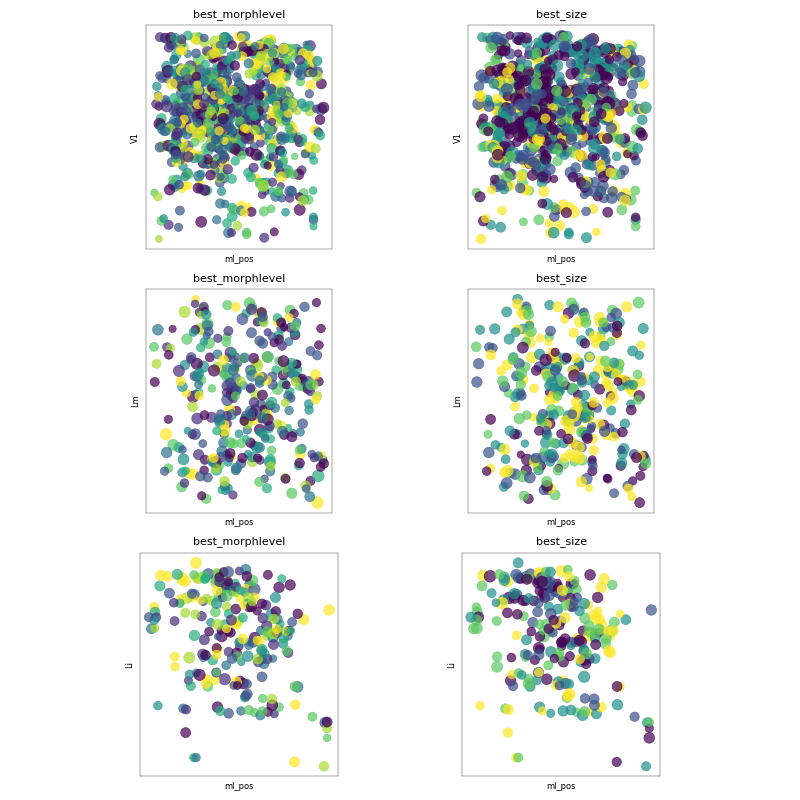

In [193]:

metric_list = ['morph_sel', 'size_tol', 'lum_sel']
metric_list = ['best_morphlevel', 'best_size']

fig, axn = pl.subplots(3,len(metric_list), figsize=(8,8))

for va, df_ in DF.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, metric in enumerate(metric_list):
        ax=axn[vi, ai]
        size_value = 'size_tol' if 'size' in metric else 'morph_sel'
        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, size=size_value,
                        size_norm=(0, 0.8),
                        edgecolor=None, alpha=0.7, legend=False,
                        vmin=0, vmax=1)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_title(metric)
        ax.set_ylabel(va)
        ax.set_xticks([])
        ax.set_yticks([])
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, top=0.8, wspace=0.2, hspace=0.4)
pl.tight_layout()